In [ ]:
import numpy as np
import cupy as cp
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from numba import njit
import time


In [ ]:
@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)

    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]

    return B


In [ ]:
@njit
def NLM_fast_cpu(img, h, f, t):
    m, n = img.shape
    filtrada = np.zeros((m, n), dtype=img.dtype)
    img_n = mirror_cpu(img, f)
    for i in range(m):
        for j in range(n):
            im = i + f
            jn = j + f
            W1 = img_n[im-f:im+f+1, jn-f:jn+f+1]
            rmin = max(im-t, f)
            rmax = min(im+t, m+f-1)
            smin = max(jn-t, f)
            smax = min(jn+t, n+f-1)
            NL = 0.0
            Z = 0.0
            for r in range(rmin, rmax+1):
                for s in range(smin, smax+1):
                    W2 = img_n[r-f:r+f+1, s-f:s+f+1]
                    d2 = np.sum((W1 - W2)**2)
                    sij = np.exp(-d2/(h**2))
                    Z += sij
                    NL += sij * img_n[r, s]
            filtrada[i, j] = NL / Z
    return filtrada


In [ ]:
def mirror_gpu(A, f):
    n, m = A.shape
    B = cp.zeros((n + 2*f, m + 2*f), dtype=A.dtype)
    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]
    return B


In [ ]:
nlm_kernel_global_code = r'''
extern "C" __global__
void nlm_kernel_global(
    const float* img_n, float* output,
    int m, int n, int f, int t, float h, int padded_width
) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= m || j >= n)
        return;

    int im = i + f;
    int jm = j + f;

    float NL = 0.0f;
    float Z = 0.0f;

    for (int r = im - t; r <= im + t; ++r) {
        for (int s = jm - t; s <= jm + t; ++s) {
            float d2 = 0.0f;
            for (int u = -f; u <= f; ++u) {
                for (int v = -f; v <= f; ++v) {
                    int x1 = im + u;
                    int y1 = jm + v;
                    int x2 = r + u;
                    int y2 = s + v;

                    float val1 = img_n[x1 * padded_width + y1];
                    float val2 = img_n[x2 * padded_width + y2];
                    float diff = val1 - val2;
                    d2 += diff * diff;
                }
            }
            float weight = __expf(-d2 / (h * h));
            Z += weight;
            NL += weight * img_n[r * padded_width + s];
        }
    }

    output[i * n + j] = NL / Z;
}
'''



In [206]:
def NLM_fast_cuda_global(img, h, f, t):
    img = img.astype(cp.float32)
    m, n = img.shape
    padded = mirror_gpu(img, f)

    module = cp.RawModule(code=nlm_kernel_global_code, options=('-std=c++11',))
    kernel = module.get_function("nlm_kernel_global")

    output = cp.zeros((m, n), dtype=cp.float32)
    threads_per_block = (16, 16)
    grid = ((n + 15) // 16, (m + 15) // 16)

    kernel(
        grid, threads_per_block,
        (
            padded.ravel(), output.ravel(),
            cp.int32(m), cp.int32(n), cp.int32(f), cp.int32(t),
            cp.float32(h), cp.int32(padded.shape[1])
        )
    )
    return output

def add_noise_gaussian(img):
    m, n = img.shape
    sigma = 10
    noise = np.random.normal(0, sigma, (m, n)).astype(np.float32)
    noised = np.clip(img + noise, 0, 255)
    return noised

def add_poisson_noise(img):    
    poisson_img = np.random.poisson(img)    
    return poisson_img

def add_poisson_gaussian_noise(image, gaussian_sigma=25):
    # Apply Poisson noise
    poisson_image = np.random.poisson(image)

    # Apply Gaussian noise
    gaussian_noise = np.random.normal(loc=0.0, scale=gaussian_sigma, size=image.shape)
    noisy_image = poisson_image + gaussian_noise 

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def downscale(img):
    img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
    return img_downscale

def anscombe_transform(img):
    return 2.0 * np.sqrt(img.astype(np.float32) + 3.0 / 8.0)

def inverse_anscombe(y):
    # Inversa exata de Makitalo & Foi (IEEE T-IP 2011)
    return ((y / 2.0)**2) - 3.0 / 8.0

def compute_adaptive_q(sigma_est, anscombe=False):
    q_nlm = 0.8 + 0.5 * np.tanh(0.3 * (sigma_est - 1))
    q_geo = 1.0 + 0.7 * np.tanh(0.25 * (sigma_est - 1.5))

    if anscombe:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 10)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 10)
    else:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 100)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 100)

    print(f'q_nlm: {q_nlm}, g_geo: {q_geo}')
    return q_nlm, q_geo

def select_best_h_using_adaptive_q(image_downscale, image_gpu, q_nlm_candidates, f, t, alpha=0.5, anscombe=False):
    melhor_score = -cp.inf
    melhor_q_nlm = None

    for h_nlm in q_nlm_candidates:
        #print(f'h_nlm: {h_nlm}')

        # Aplica NLM na imagem transformada
        result_gpu = NLM_fast_cuda_global(image_gpu, h_nlm, f, t)
        cp.cuda.Stream.null.synchronize()

        if anscombe:
            # Aplica inversa de Anscombe
            result_gpu_inverse = inverse_anscombe(cp.asnumpy(result_gpu))

            # Referência: imagem original (antes do ruído e da transformada)
            img_ref = np.clip(image_downscale, 0, 255).astype(np.uint8)
            result_uint8 = np.clip(result_gpu_inverse, 0, 255).astype(np.uint8)
        else:
            # Métricas PSNR e SSIM em relação à imagem original
            img_ref = np.clip(image_downscale, 0, 255).astype(np.uint8)        
            result_uint8 = np.clip(result_gpu, 0, 255).astype(np.uint8).get()

        # Métricas
        psnr = peak_signal_noise_ratio(img_ref, result_uint8, data_range=255)
        ssim = structural_similarity(img_ref, result_uint8, data_range=255)

        # Score combinado
        score = alpha * psnr + (1 - alpha) * (ssim * 100)

        #print(f"h = {h_nlm:.2f} | PSNR = {psnr:.2f} | SSIM = {ssim:.4f} | Score = {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_q_nlm = h_nlm

    print(f"\n[SELECIONADO] q_nlm = {melhor_q_nlm:.2f} | h_nlm = {melhor_q_nlm:.2f} ")

    return melhor_q_nlm

### Testando

Tempo CPU: 126.8388192653656
Tempo GPU: 0.009395360946655273
Diferença média: 0.0101
Diferença máxima: 5.1274

--- Métricas de Qualidade ---
PSNR (CPU NLM):  33.35 dB
PSNR (CUDA NLM): 33.35 dB
SSIM (CPU NLM):  0.9126
SSIM (CUDA NLM): 0.9126


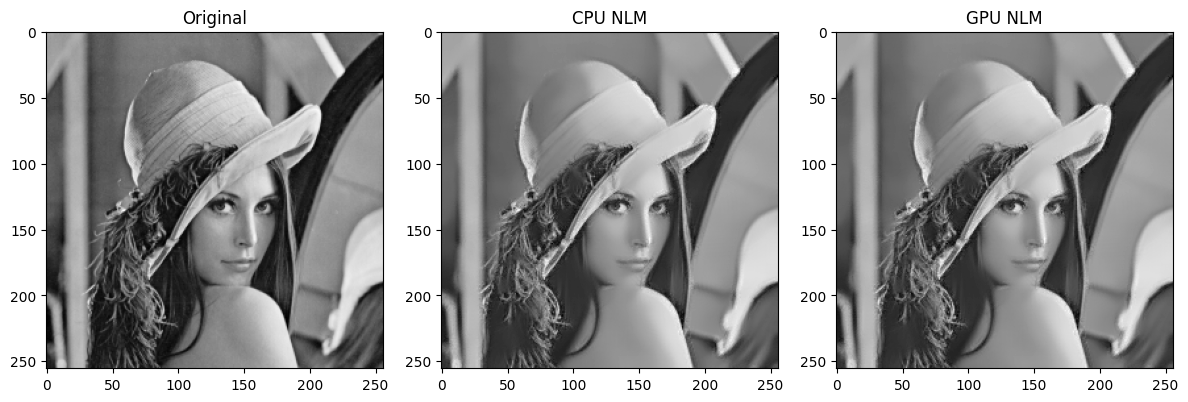

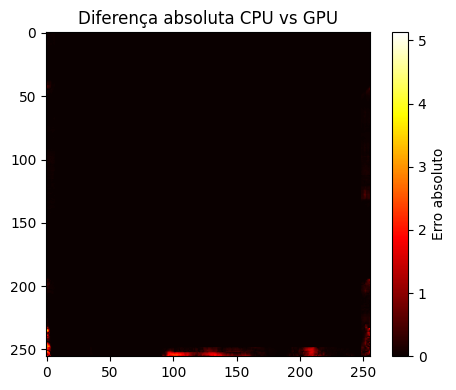

In [179]:
# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape
sigma = 10
ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
ruidosa = np.clip(img_downscale + ruido, 0, 255)

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
img_gpu = cp.array(img_cpu)

# Parâmetros do filtro
h = 110
f = 4
t = 7

# ------------------------------- CPU -------------------------------
start_cpu = time.time()
result_cpu = NLM_fast_cpu(img_cpu, h, f, t)
print("Tempo CPU:", time.time() - start_cpu)

# ------------------------------- GPU -------------------------------
start_gpu = time.time()
result_gpu = NLM_fast_cuda_global(img_gpu, h, f, t)
cp.cuda.Stream.null.synchronize()
print("Tempo GPU:", time.time() - start_gpu)

# Comparação
result_gpu_cpu = cp.asnumpy(result_gpu)
diff = np.abs(result_cpu - result_gpu_cpu)
print(f'Diferença média: {diff.mean():.4f}')
print(f'Diferença máxima: {diff.max():.4f}')

# Métricas PSNR e SSIM em relação à imagem original
img_ref = np.clip(img_downscale, 0, 255).astype(np.uint8)
result_cpu_uint8 = np.clip(result_cpu, 0, 255).astype(np.uint8)
result_gpu_uint8 = np.clip(result_gpu_cpu, 0, 255).astype(np.uint8)

psnr_cpu = peak_signal_noise_ratio(img_ref, result_cpu_uint8, data_range=255)
psnr_gpu = peak_signal_noise_ratio(img_ref, result_gpu_uint8, data_range=255)
ssim_cpu = structural_similarity(img_ref, result_cpu_uint8, data_range=255)
ssim_gpu = structural_similarity(img_ref, result_gpu_uint8, data_range=255)

print(f'\n--- Métricas de Qualidade ---')
print(f'PSNR (CPU NLM):  {psnr_cpu:.2f} dB')
print(f'PSNR (CUDA NLM): {psnr_gpu:.2f} dB')
print(f'SSIM (CPU NLM):  {ssim_cpu:.4f}')
print(f'SSIM (CUDA NLM): {ssim_gpu:.4f}')

# Visualizações
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_ref, cmap='gray')
plt.subplot(1,3,2); plt.title("CPU NLM"); plt.imshow(result_cpu, cmap='gray')
plt.subplot(1,3,3); plt.title("GPU NLM"); plt.imshow(result_gpu_cpu, cmap='gray')
plt.tight_layout(); plt.show()

# Diferença absoluta entre CPU e GPU
plt.figure(figsize=(5,4))
plt.title("Diferença absoluta CPU vs GPU")
plt.imshow(diff, cmap='hot')
plt.colorbar(label='Erro absoluto')
plt.tight_layout()
plt.show()

In [ ]:
from skimage.io import imsave
imsave("cpu_result.png", np.clip(result_cpu, 0, 255).astype(np.uint8))
imsave("gpu_result.png", np.clip(result_gpu_cpu, 0, 255).astype(np.uint8))
imsave("abs_diff.png", np.clip(diff * 10, 0, 255).astype(np.uint8))

### Noise Gaussian

In [180]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape
sigma = 10
ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
ruidosa = np.clip(img_downscale + ruido, 0, 255)

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
estimated_sigma = estimate_sigma(img_cpu)
img_gpu = cp.array(img_cpu)


h_nlm , g_nlm = compute_adaptive_q(estimated_sigma)

q_nlm_candidates = np.array([h_nlm + delta for delta in range(-50, 25, 1)])

print(f'q_nlm_candidates: {q_nlm_candidates}')
# Parâmetros do filtro

q_nlm: 129, g_geo: 168
q_nlm_candidates: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153]


In [181]:
h_nlm_final =  select_best_h_using_adaptive_q(img_downscale, img_gpu, q_nlm_candidates, f=4, t=7, alpha=0.5)

h_nlm: 79
h = 79.00 | PSNR = 32.11 | SSIM = 0.9059 | Score = 61.35
h_nlm: 80
h = 80.00 | PSNR = 32.19 | SSIM = 0.9075 | Score = 61.47
h_nlm: 81
h = 81.00 | PSNR = 32.27 | SSIM = 0.9089 | Score = 61.58
h_nlm: 82
h = 82.00 | PSNR = 32.34 | SSIM = 0.9102 | Score = 61.68
h_nlm: 83
h = 83.00 | PSNR = 32.42 | SSIM = 0.9114 | Score = 61.78
h_nlm: 84
h = 84.00 | PSNR = 32.49 | SSIM = 0.9124 | Score = 61.87
h_nlm: 85
h = 85.00 | PSNR = 32.56 | SSIM = 0.9133 | Score = 61.94
h_nlm: 86
h = 86.00 | PSNR = 32.62 | SSIM = 0.9141 | Score = 62.01
h_nlm: 87
h = 87.00 | PSNR = 32.68 | SSIM = 0.9147 | Score = 62.07
h_nlm: 88
h = 88.00 | PSNR = 32.74 | SSIM = 0.9153 | Score = 62.13
h_nlm: 89
h = 89.00 | PSNR = 32.79 | SSIM = 0.9158 | Score = 62.18
h_nlm: 90
h = 90.00 | PSNR = 32.84 | SSIM = 0.9161 | Score = 62.23
h_nlm: 91
h = 91.00 | PSNR = 32.89 | SSIM = 0.9163 | Score = 62.26
h_nlm: 92
h = 92.00 | PSNR = 32.94 | SSIM = 0.9165 | Score = 62.30
h_nlm: 93
h = 93.00 | PSNR = 32.99 | SSIM = 0.9167 | Score = 6

### Noise Poisson

In [182]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_noise(img_downscale)
print(f'ruidosa: {type(ruidosa)}')

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')


h_nlm , g_nlm = compute_adaptive_q(estimated_sigma)

q_nlm_candidates_poisson = np.array([h_nlm + delta for delta in range(-30, 30, 1)])

print(f'q_nlm_candidates: {q_nlm_candidates_poisson}')
# Parâmetros do filtro

ruidosa: <class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 11.39524652506921
img_gpu: <class 'cupy.ndarray'>
q_nlm: 129, g_geo: 169
q_nlm_candidates: [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158]


In [183]:
h_nlm_final_poisson =  select_best_h_using_adaptive_q(img_downscale, img_gpu, q_nlm_candidates_poisson, f=4, t=7, alpha=0.5)

h_nlm: 99
h = 99.00 | PSNR = 32.21 | SSIM = 0.8993 | Score = 61.07
h_nlm: 100
h = 100.00 | PSNR = 32.26 | SSIM = 0.9001 | Score = 61.14
h_nlm: 101
h = 101.00 | PSNR = 32.31 | SSIM = 0.9007 | Score = 61.19
h_nlm: 102
h = 102.00 | PSNR = 32.36 | SSIM = 0.9013 | Score = 61.25
h_nlm: 103
h = 103.00 | PSNR = 32.41 | SSIM = 0.9019 | Score = 61.30
h_nlm: 104
h = 104.00 | PSNR = 32.45 | SSIM = 0.9023 | Score = 61.34
h_nlm: 105
h = 105.00 | PSNR = 32.49 | SSIM = 0.9027 | Score = 61.38
h_nlm: 106
h = 106.00 | PSNR = 32.53 | SSIM = 0.9030 | Score = 61.42
h_nlm: 107
h = 107.00 | PSNR = 32.56 | SSIM = 0.9031 | Score = 61.44
h_nlm: 108
h = 108.00 | PSNR = 32.59 | SSIM = 0.9033 | Score = 61.46
h_nlm: 109
h = 109.00 | PSNR = 32.62 | SSIM = 0.9034 | Score = 61.48
h_nlm: 110
h = 110.00 | PSNR = 32.64 | SSIM = 0.9034 | Score = 61.49
h_nlm: 111
h = 111.00 | PSNR = 32.66 | SSIM = 0.9033 | Score = 61.50
h_nlm: 112
h = 112.00 | PSNR = 32.68 | SSIM = 0.9032 | Score = 61.50
h_nlm: 113
h = 113.00 | PSNR = 32.70

### Poisson com Anscombe

In [184]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale_poisson = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_noise(img_downscale_poisson)
print(f'ruidosa: {type(ruidosa)}')

ruidosa_anscombe = anscombe_transform(ruidosa)
print(type(ruidosa_anscombe))

# Preparo para CPU e GPU
img_cpu = ruidosa_anscombe.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu, channel_axis=None)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')

h_nlm, g_nlm = compute_adaptive_q(estimated_sigma, anscombe=True)

h_nlm, g_nlm = h_nlm, g_nlm

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm + delta for delta in range(-10, 10, 1) if (h_nlm + delta) >= 1]
)

print(f'q_nlm_candidates_poisson_gaussian: {img_downscale_poisson, q_nlm_candidates_poisson_gaussian}')
# Parâmetros do filtro



ruidosa: <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 1.0721074963082775
img_gpu: <class 'cupy.ndarray'>
q_nlm: 8, g_geo: 9
q_nlm_candidates_poisson_gaussian: (array([[162.  , 161.5 , 159.5 , ..., 168.5 , 170.5 , 141.5 ],
       [162.  , 161.5 , 159.5 , ..., 168.5 , 170.5 , 141.5 ],
       [163.  , 159.  , 159.75, ..., 157.75, 151.  , 115.75],
       ...,
       [ 51.  ,  51.  ,  53.5 , ...,  81.  ,  92.5 ,  91.75],
       [ 44.5 ,  49.25,  50.5 , ...,  92.5 , 101.5 ,  98.  ],
       [ 44.  ,  56.75,  50.5 , ..., 100.5 , 102.  , 106.5 ]],
      dtype=float32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))


In [185]:
h_nlm_final_poisson_gaussian =  select_best_h_using_adaptive_q(img_downscale_poisson,img_gpu, q_nlm_candidates_poisson_gaussian, f=4, t=7, alpha=0.5, anscombe=True)

h_nlm: 1
h = 1.00 | PSNR = 27.17 | SSIM = 0.6653 | Score = 46.85
h_nlm: 2
h = 2.00 | PSNR = 27.17 | SSIM = 0.6653 | Score = 46.85
h_nlm: 3
h = 3.00 | PSNR = 27.25 | SSIM = 0.6691 | Score = 47.08
h_nlm: 4
h = 4.00 | PSNR = 27.40 | SSIM = 0.6746 | Score = 47.43
h_nlm: 5
h = 5.00 | PSNR = 27.87 | SSIM = 0.6989 | Score = 48.88
h_nlm: 6
h = 6.00 | PSNR = 29.38 | SSIM = 0.7908 | Score = 54.23
h_nlm: 7
h = 7.00 | PSNR = 30.89 | SSIM = 0.8705 | Score = 58.97
h_nlm: 8
h = 8.00 | PSNR = 31.95 | SSIM = 0.9037 | Score = 61.16
h_nlm: 9
h = 9.00 | PSNR = 32.63 | SSIM = 0.9138 | Score = 62.01
h_nlm: 10
h = 10.00 | PSNR = 33.02 | SSIM = 0.9151 | Score = 62.27
h_nlm: 11
h = 11.00 | PSNR = 33.18 | SSIM = 0.9123 | Score = 62.21
h_nlm: 12
h = 12.00 | PSNR = 33.14 | SSIM = 0.9075 | Score = 61.94
h_nlm: 13
h = 13.00 | PSNR = 32.92 | SSIM = 0.9012 | Score = 61.52
h_nlm: 14
h = 14.00 | PSNR = 32.54 | SSIM = 0.8936 | Score = 60.95
h_nlm: 15
h = 15.00 | PSNR = 32.04 | SSIM = 0.8851 | Score = 60.27
h_nlm: 16
h =

### Poisson Gaussian Anscombe

In [194]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/4.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_gaussian_noise(img_downscale)
print(f'ruidosa: {type(ruidosa)}')

ruidosa_anscombe = anscombe_transform(ruidosa)
print(type(ruidosa_anscombe))

# Preparo para CPU e GPU
img_cpu = ruidosa_anscombe.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu)# channel_axis=None)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')


h_nlm, g_nlm = compute_adaptive_q(estimated_sigma, anscombe=True)

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm + delta for delta in range(-30, 30, 1) if (h_nlm + delta) >= 1]
)

print(f'q_nlm_candidates_poisson_gaussian: {q_nlm_candidates_poisson_gaussian}')

ruidosa: <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 3.1639700811061724
img_gpu: <class 'cupy.ndarray'>
q_nlm: 10, g_geo: 12
q_nlm_candidates_poisson_gaussian: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [195]:
h_nlm_final_poisson_gaussian =  select_best_h_using_adaptive_q(img_downscale, img_gpu, q_nlm_candidates_poisson_gaussian, f=4, t=7, alpha=0.5, anscombe=True)

h_nlm: 1
h = 1.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 2
h = 2.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 3
h = 3.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 4
h = 4.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 5
h = 5.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 6
h = 6.00 | PSNR = 19.75 | SSIM = 0.3629 | Score = 28.02
h_nlm: 7
h = 7.00 | PSNR = 19.75 | SSIM = 0.3630 | Score = 28.02
h_nlm: 8
h = 8.00 | PSNR = 19.77 | SSIM = 0.3635 | Score = 28.06
h_nlm: 9
h = 9.00 | PSNR = 19.80 | SSIM = 0.3646 | Score = 28.13
h_nlm: 10
h = 10.00 | PSNR = 19.83 | SSIM = 0.3656 | Score = 28.19
h_nlm: 11
h = 11.00 | PSNR = 19.85 | SSIM = 0.3663 | Score = 28.24
h_nlm: 12
h = 12.00 | PSNR = 19.88 | SSIM = 0.3674 | Score = 28.31
h_nlm: 13
h = 13.00 | PSNR = 19.97 | SSIM = 0.3705 | Score = 28.51
h_nlm: 14
h = 14.00 | PSNR = 20.16 | SSIM = 0.3782 | Score = 28.99
h_nlm: 15
h = 15.00 | PSNR = 20.50 | SSIM = 0.3924 | Score = 29.87
h_nlm: 16
h =

In [207]:
# Carregamento da imagem
img_path = '../images/1.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

img_downscale = downscale(img)

img_noise_gaussian = add_noise_gaussian(img_downscale)

img_noise_poisson = add_poisson_noise(img_downscale)
noised_anscombe_poisson = anscombe_transform(img_noise_poisson)

img_noise_poisson_gaussian = add_poisson_gaussian_noise(img_downscale)
noised_anscombe_poisson_gaussian = anscombe_transform(img_noise_poisson_gaussian)

# Gaussian
img_cpu_gaussian = img_noise_gaussian.astype(np.float32)
print(f'img_cpu_gaussian: {type(img_cpu_gaussian)}')

estimated_sigma_gaussian = estimate_sigma(img_cpu_gaussian)# channel_axis=None)
print(f'estimated_sigma_gaussian: {(estimated_sigma_gaussian)}')
img_gpu_gaussian = cp.array(img_cpu_gaussian)
print(f'img_gpu_gaussian: {type(img_gpu_gaussian)}')

h_nlm_gaussian, g_nlm_gaussian = compute_adaptive_q(estimated_sigma_gaussian)

q_nlm_candidates_gaussian = np.array(
    [h_nlm_gaussian + delta for delta in range(-30, 30, 1) if (h_nlm_gaussian + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_gaussian}')

h_nlm_final_gaussian =  select_best_h_using_adaptive_q(img_downscale, img_gpu_gaussian, q_nlm_candidates_gaussian, f=4, t=7, alpha=0.5)


# Poisson
img_cpu_poisson = noised_anscombe_poisson.astype(np.float32)
print(f'img_cpu_poisson: {type(img_cpu_poisson)}')

estimated_sigma_poisson = estimate_sigma(img_cpu_poisson)# channel_axis=None)
print(f'estimated_sigma_poisson: {(estimated_sigma_poisson)}')
img_gpu_poisson = cp.array(img_cpu_poisson)
print(f'img_gpu_poisson: {type(img_gpu_poisson)}')

h_nlm_poisson, g_nlm_poisson = compute_adaptive_q(estimated_sigma_poisson, anscombe=True)

q_nlm_candidates_poisson = np.array(
    [h_nlm_poisson + delta for delta in range(-30, 30, 1) if (h_nlm_poisson + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_poisson}')

h_nlm_final_poisson =  select_best_h_using_adaptive_q(img_downscale, img_gpu_poisson, q_nlm_candidates_poisson, f=4, t=7, alpha=0.5, anscombe=True)


# Poisson Gaussian
img_cpu_poisson_gaussian = noised_anscombe_poisson_gaussian.astype(np.float32)
print(f'img_cpu_poisson_gaussian: {type(img_cpu_poisson_gaussian)}')

estimated_sigma_poisson_gaussian = estimate_sigma(img_cpu_poisson_gaussian)# channel_axis=None)
print(f'estimated_sigma_poisson_gaussian: {(estimated_sigma_poisson_gaussian)}')
img_gpu_poisson_gaussian = cp.array(img_cpu_poisson_gaussian)
print(f'img_gpu_poisson_gaussian: {type(img_gpu_poisson_gaussian)}')

h_nlm_poisson_gaussian, g_nlm_poisson_gaussian = compute_adaptive_q(estimated_sigma_poisson_gaussian, anscombe=True)

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm_poisson_gaussian + delta for delta in range(-30, 30, 1) if (h_nlm_poisson_gaussian + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_poisson_gaussian}')

h_nlm_final_poisson_gaussian =  select_best_h_using_adaptive_q(img_downscale, img_gpu_poisson_gaussian, q_nlm_candidates_poisson_gaussian, f=4, t=7, alpha=0.5, anscombe=True)




img_cpu_gaussian: <class 'numpy.ndarray'>
estimated_sigma_gaussian: 12.403581914707205
img_gpu_gaussian: <class 'cupy.ndarray'>
q_nlm: 129, g_geo: 169

[SELECIONADO] q_nlm = 101.00 | h_nlm = 101.00 
img_cpu_poisson: <class 'numpy.ndarray'>
estimated_sigma_poisson: 1.2469341550565667
img_gpu_poisson: <class 'cupy.ndarray'>
q_nlm: 8, g_geo: 9

[SELECIONADO] q_nlm = 10.00 | h_nlm = 10.00 
img_cpu_poisson_gaussian: <class 'numpy.ndarray'>
estimated_sigma_poisson_gaussian: 2.8536184278820325
img_gpu_poisson_gaussian: <class 'cupy.ndarray'>
q_nlm: 10, g_geo: 12

[SELECIONADO] q_nlm = 28.00 | h_nlm = 28.00 
